# Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML

# Importing and Transforming Scraped Data

In [42]:
#Reading in scraped data
raw_data = pd.read_csv('mydealz_data.csv',skipinitialspace=True)

#creating new feature local_deal
local_deal = raw_data['publication_date'].str.find('lokal')
raw_data['local_deal'] = np.where(local_deal != -1,True,False)

#removing characters from title column
raw_data['title'].replace(to_replace='\n\t',value='',regex=True,inplace=True)

#removing characters from temp1, temp 2, temp 3 column
raw_data[['temp1','temp2','temp3']] = raw_data[['temp1','temp2','temp3']].replace(to_replace=['\n\t\t','°\n\t','°'],value=['','',''],regex=True)

#combining temp1, temp2 and temp3 to one column
raw_data['temperature'] = raw_data['temp1'].fillna(raw_data['temp2']).fillna(raw_data['temp3'])

#dropping other temp labels afterwards
raw_data.drop(labels=['temp1','temp2','temp3'],axis=1)

#changing data type to numeric
raw_data['temperature'] = pd.to_numeric(raw_data['temperature'])

#removing characters from old_price and new_price
raw_data[['old_price','new_price']] = raw_data[['old_price','new_price']].replace(to_replace={'€':''},regex=True)
raw_data['old_price'] = raw_data['old_price'].str.replace('.','').str.replace(',','.')
raw_data['new_price'] = raw_data['new_price'].str.replace('.','').str.replace(',','.').str.replace('KOSTENLOS','0')
raw_data['old_price'] = pd.to_numeric(raw_data['old_price'])
raw_data['new_price'] = pd.to_numeric(raw_data['new_price'])

#calculating discount
raw_data['discount'] = (raw_data['old_price']- raw_data['new_price'])/raw_data['old_price']

#removing characters from deal link
raw_data['deal_link'] = raw_data['deal_link'].str.replace('http://twitter.com/intent/tweet\?url=','',1)
raw_data['deal_link'] = raw_data['deal_link'].str.split('&text').str[0]

#removing characters from description
raw_data['description'].replace(to_replace=['\t\t\t','\n'],value=['',''],regex=True,inplace=True)

#transforming date
abbreviation_dictionary = {
        ' Jan':'01',
        ' Feb':'02',
        ' Mär':'03',
        ' Apr':'04',
        ' Mai':'05',
        ' Jun':'06',
        ' Jul':'07',
        ' Aug':'08',
        ' Sep':'09',
        ' Okt':'10',
        ' Nov':'11',
        ' Dez':'12',
    }   

def transform_date(x):
    if x.find('eingestellt vor') != -1:
        return '9.12.2018'
    elif x.find('aktualisiert') != -1:
        x = x[x.find('eingestellt')+12:x.find(')')]
        if len(x) <= 7:
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.2018')
            return x
        else: 
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.')
            return x
    elif x.find('eingestellt') != -1:
        x = x[x.find('eingestellt')+15:]
        if len(x) <= 7:
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.2018')
            return x
        else: 
            for month,number in abbreviation_dictionary.items():
                x = x.replace(month,number+'.')
            return x
    else:
        return x

raw_data['publication_date'] = raw_data['publication_date'].apply(transform_date)
raw_data['publication_date'] = raw_data['publication_date'].replace(' ','',regex= True)
raw_data['publication_date'] = pd.to_datetime(raw_data['publication_date'])

#encoding local deal
def encoding(x):
    if x == True:
        return 1
    elif x == False:
        return 0

raw_data['local_deal'] = raw_data['local_deal'].apply(encoding)

#creating final data frame
mydealz_data = raw_data[['title','temperature','old_price','new_price','discount','username', 'number_of_comments','local_deal','description','publication_date','deal_link',]]

#mydealz_data.to_csv('mydealz_final_dataset.csv')

# Data Analysis

## General Overview

In [43]:
mydealz_data.head(3)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
0,"Seeberger Müsliglück Sunday Morning, 6er Pack (6 x 325 g) [AMAZON Sparabo]",126,11.94,8.54,0.284757,0815Hamster,14,0,"Eine Packung kostet sonst mindestens 1,99 €, wenn nicht noch mehr!Andere Sorten sind auch im Angebot.Fruchtige Orangenstückchen und weiße SchokoladeErinnert an das Capri-Eis aus Kindertagen",2018-09-12,https://www.mydealz.de/deals/seeberger-musligluck-sunday-morning-6er-pack-6-x-325-g-amazon-sparabo-1292579
1,"Philips Hue White and Color Ambiance E14 LED Kerze Doppelpack inkl. Hue Dimmschalter, dimmbar, steuerbar via App, für 75,59€ (Amazon)",215,93.94,75.59,0.195337,Funmilka,8,0,"Moin,bei Amazon bekommt ihr derzeit als Tagesangebot das Philips Hue White and Color Ambiance E14 LED Kerze Doppelpack inkl. Hue Dimmschalter, dimmbar, steuerbar via App, für 75,59€ inkl. Versandkosten.Preisvergleich: 73,99€ (Doppelpack)Preisvergleich: 43,00€ (Einzelne Lampe)Preisvergleich: 19,95€ (Hue Dimmschalter)Mit unseren Hue Erweiterungen können Sie Ihr Hue System nach Belieben erweitern und das Licht-Erlebnis auf weitere Wohnräume ausweiten. Die White und Color Ambiance Erweiterung ist die Premium-Erweiterung mit allen Funktionalitäten, allen Weißtönen und allen Farben, die das Lichtspektrum zu bieten hat, von einem orangefarbenen warmweißen Licht bis hin zu einem bläulichen kühleren Licht, das dem Tageslicht ähnelt. Den beiliegenden Dimmschalter können Sie an der Wand befestigen und wie einen herkömmlichen Lichtschalter nutzen, oder nach Belieben abnehmen für die Nutzung als Fernbedienung. Erweiterung für das Philips Hue System - 2x Hue LED WiFi Lampe für alle Philips Hue ...",2018-09-12,https://www.mydealz.de/deals/philips-hue-white-and-color-ambiance-e14-led-kerze-doppelpack-inkl-hue-dimmschalter-dimmbar-steuerbar-via-app-fur-7559eur-amazon-1292626
2,"[Regional Mediamarkt Nordhorn-Tagesangebot am 10.12] Bose SoundTouch 10 / Doppelpack schwarz für 249,-€",103,308.00,249.00,0.191558,The_Old_Dude_aka_Mimic,2,1,"Und noch einmal einen schönen 2.Advent für alle die jetzt erst zuschalten. Nur am kommenden Montag bekommt ihr im Mediamarkt Nordhorn das folgende Angebot...► Bose SoundTouch 10 / Doppelpack schwarz für 249,-€◄Idealopreis: 308€ (Einzelkauf von 2 Stück)Denkt an dem Tag daran, auch in den einzelnen Bose Stores nach dem Preis zu fragen!HerstellerBoseProdukttypWLAN Lautsprecher, Bluetooth LautsprecherSerieBose SoundTouchBetriebPrinzipaktivStromversorgungNetzteilAusstattungintegrierte GeräteMP3-Player, USB-PlayerFunktionInternetradio, DLNA, StreamingWiedergabeformateMP3EmpfangsbereichWebradioverfügbarer MusikdienstiTunes, Deezer, SpotifySteuerung überTasten, Fernbedienung, AppSteuerungseigenschaftEin/Aus, Lautstärke, Bluetooth Pairing, AUX-In, 6 Presets für MusikquellenSmartphone Steuerungs-AppBose SoundTouchApp verfügbar füriOS, Android, Mac, WindowsLeistungVerstärkertypdigitalAnschlüsseanaloger EingangLine-In (3,5mm Klinke)digitaler EingangUSBweiterer AnschlussNetzwerkanschluss LAN (R...",2018-09-12,https://www.mydealz.de/deals/regional-mediamarkt-nordhorn-tagesangebot-am-1012-bose-soundtouch-10-doppelpack-schwarz-fur-249-eur-1292649


In [44]:
mydealz_data.describe()

,temperature,old_price,new_price,discount,number_of_comments,local_deal
count,63415.000000,40862.000000,54968.000000,40862.000000,63415.000000,63415.000000
mean,532.942884,241.857068,223.439065,0.311186,37.782007,0.123851
std,694.053675,785.683735,1150.348417,0.203570,166.211209,0.329414
min,0.000000,0.080000,-920.000000,0.000058,0.000000,0.000000
25%,236.000000,21.950000,11.420000,0.166290,8.000000,0.000000
50%,337.000000,63.795000,39.980000,0.256413,16.000000,0.000000
75%,526.000000,219.900000,169.520000,0.400473,33.000000,0.000000
max,22386.000000,60000.000000,151080.000000,1.000000,22733.000000,1.000000


In [45]:
mydealz_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63415 entries, 0 to 63414
Data columns (total 11 columns):
title                 63415 non-null object
temperature           63415 non-null int64
old_price             40862 non-null float64
new_price             54968 non-null float64
discount              40862 non-null float64
username              63415 non-null object
number_of_comments    63415 non-null int64
local_deal            63415 non-null int64
description           63389 non-null object
publication_date      63415 non-null datetime64[ns]
deal_link             63415 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 5.3+ MB


## Explanatory Data Analysis

In [6]:
#Increasing column width for readability
pd.set_option('display.max_colwidth',1000)

## Deal Temperature

How is the overall distribution of the temperature of deals?

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


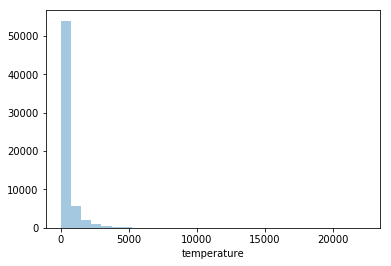

In [7]:
sns.distplot(mydealz_data['temperature'],kde=False,bins=30)

What is the average deal temperature?

In [8]:
mydealz_data['temperature'].mean()

532.9428841756683

What where the top 3 hottest overall deals on MyDealz?

In [9]:
mydealz_data.sort_values(by='temperature',ascending=False).head(3)[['title','temperature','deal_link','description','publication_date']]

,title,temperature,deal_link,description,publication_date
28810,19%-MwSt-geschenkt-Aktion am 21. und 22.09.2018 bei Media Markt und Saturn on- und offline,22386,https://www.mydealz.de/deals/19-mwst-geschenkt-aktion-am-21-und-22092018-bei-media-markt-und-saturn-on-und-offline-1230945,"Bei Media Markt startet am 21 und 22.09.2018 wieder eine 19% MwSt geschenkt Aktion auf alle Artikel . Z.b wird es den GQ65Q9FNG statt für 3059€ für 2477,79€. Das beste Angebot ist bei idealo mit 2639€ also spart über 160€",2018-07-09
51320,10€ Rabatt ohne MBW (unbegrenzt oft) auf alles bei Amazon durch Spiele-Gutscheinfehler,18021,https://www.mydealz.de/deals/10eur-rabatt-ohne-mbw-unbegrenzt-oft-auf-alles-bei-amazon-durch-spiele-gutscheinfehler-1126286,"Auch auf die Gefahr hin, dass nun alles was ich bestellt habe gecancelled wird, hier ein grandioser Deal:Legt ein Spiel bei Amazon in den Einkaufswagen (wichtig, dass es kein Marketplacehändler, sondern Amazon selber ist) und geht zur Kasse.Es werden dann 10€ abgezogen.Ihr könnt jetzt einfach noch ein anderes Produkt in den Warenkorb legen (einzige Bedingung: ""Verkauf und Versand durch Amazon"") und das Spiel dann an der Kasse (also im letzten Bestellschritt) wieder entfernen. Die 10€ Rabatt bleiben bestehen!Somit extrem viele Freebies möglich.Funktioniert sooft man möchte.Auf zwei Accounts getestet.",2018-07-02
57519,Geleakte Mediamarkt Geschenkkarten Aktion 2016 [20.12. - 21.12.],17746,https://www.mydealz.de/deals/geleakte-mediamarkt-geschenkkarten-aktion-2016-2012-2112-903656,"Ursprünglicher Deal vom 12.12.2016Bisher wurde die Aktion noch nicht veröffentlicht, jedoch sieht es so aus als würde es dieses Jahr wieder eine Geschenkkarten Aktion geben indem man 50€ für eine 60€ Geschenkkarte bei Mediamarkt bezahlt. Falls es stimmen sollte denke ich mega hot",2016-12-12


What were the top 10 hottest deals in 2018?

In [10]:
mydealz_data[(mydealz_data['publication_date'] > '01.01.2018') & (mydealz_data['publication_date'] < '31.12.2018')].sort_values(by='temperature',ascending=False).head(10)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
28810,19%-MwSt-geschenkt-Aktion am 21. und 22.09.2018 bei Media Markt und Saturn on- und offline,22386,NaN,NaN,NaN,Redsoldier,6491,0,"Bei Media Markt startet am 21 und 22.09.2018 wieder eine 19% MwSt geschenkt Aktion auf alle Artikel . Z.b wird es den GQ65Q9FNG statt für 3059€ für 2477,79€. Das beste Angebot ist bei idealo mit 2639€ also spart über 160€",2018-07-09,https://www.mydealz.de/deals/19-mwst-geschenkt-aktion-am-21-und-22092018-bei-media-markt-und-saturn-on-und-offline-1230945
51320,10€ Rabatt ohne MBW (unbegrenzt oft) auf alles bei Amazon durch Spiele-Gutscheinfehler,18021,NaN,NaN,NaN,philippmb,12770,0,"Auch auf die Gefahr hin, dass nun alles was ich bestellt habe gecancelled wird, hier ein grandioser Deal:Legt ein Spiel bei Amazon in den Einkaufswagen (wichtig, dass es kein Marketplacehändler, sondern Amazon selber ist) und geht zur Kasse.Es werden dann 10€ abgezogen.Ihr könnt jetzt einfach noch ein anderes Produkt in den Warenkorb legen (einzige Bedingung: ""Verkauf und Versand durch Amazon"") und das Spiel dann an der Kasse (also im letzten Bestellschritt) wieder entfernen. Die 10€ Rabatt bleiben bestehen!Somit extrem viele Freebies möglich.Funktioniert sooft man möchte.Auf zwei Accounts getestet.",2018-07-02,https://www.mydealz.de/deals/10eur-rabatt-ohne-mbw-unbegrenzt-oft-auf-alles-bei-amazon-durch-spiele-gutscheinfehler-1126286
46065,"[REWE] 10% z.B. auf Amazon/MediaMarkt/Saturn Guthaben durch deingutschein, 20% auf C&A, Aktion-Mensch extra Los, KITKAT RUBY",16629,NaN,NaN,NaN,lolnickname,5978,0,"Heute ist der letzte Tag!Ab 07.05.2018 bis 12.05.2018 gibt es bei Rewe verschiedene Geschenkkarten reduziert.Die deingutschein Karte ist um 10% reduziert. Diese ist individuell aufladbar von 15 - 150 €. Über diese lässt sich dann z.B. Amazonguthaben bestellen.Außerdem sind C&A Karten um 20% reduziert.Wer ein Aktion–Mensch-Losgutschein kauft erhält auf dem Bon ein zusätzliches Los.Außerdem wird in der Woche das neue KITKAT RUBY im Rewe erhältlich sein.41,5g pro Packung für 1,29€Rewe ist erstmal der einzige Einzelhändler in Deutschland der diese Sorte im Sortiment hat. Quelle",2018-04-24,https://www.mydealz.de/deals/rewe-10-zb-auf-amazonmediamarktsaturn-guthaben-durch-deingutschein-20-auf-ca-aktion-mensch-extra-los-kitkat-ruby-1165005
51556,McDonalds Tages Coupons ab 22.02,15734,NaN,1.00,NaN,Hr._K,2352,0,"Ursprünglicher Deal vom 01.02.2018:Ab dem 22.2 gibt es bei MC Donalds, in ganz Deutschland Tages Coupons, die nur einen Tag Gültigkeit haben. Es beginnt mit Bigmac für 1€ am 1. Tag. Die darauf folgenden Tage seht Ihr im Bild. Die Aktion endet am 25.3. diese Coupons wird es nur in der App geben d.h. Ihr braucht die App!Als kleine ""Goodies"" gibt es an bestimmten Tagen z.b. Socken oder einen Schokohasen.Die Aktion heisst ""Der grosse Oster Countdown"" Ostern= Fastenzeit 14.2-31.3 Na dann viel Spass beim Fasten.",2018-01-02,https://www.mydealz.de/deals/mcdonalds-tages-coupons-ab-2202-1123254
39745,24 McNuggets (4x 6er) bei McDonald's mit 6 Saucen für 3€,14729,NaN,3.00,NaN,makuh,1756,0,"Mit dem Code 522 bekommt ihr am Bestellterminal 24 Nuggets mit 6 Saucen für nur unglaubliche 3€. Hat bei mir nicht in allen Filialen geklappt (da meinte das Terminal Bestellung sei unvollständig).Am besten direkt am Terminal bezahlen. Wo genau der Code herkommt weiß ich auch nicht. Einlösbar ab 10:30, feiertags 11.30",2018-07-18,https://www.mydealz.de/deals/24-mcnuggets-4x-6er-bei-mcdonalds-mit-6-saucen-fur-3eur-1205104
24071,"*LETZTER TAG* Drillisch Megadeal: kein Anschlusspreis auf monatlich kündbare Verträge: winSIM LTE Allnet 1GB für 6,99€, PremiumSIM LTE 2GB für 6,99€, winSIM LTE Allnet 3GB für 7,99€, PremiumSIM LTE 4GB für 9,99€ uvm.",14097,NaN,6.99,NaN,El_Lorenzo,2323,0,"Bei Drillisch kommt hier ein richtiger Knaller reingeflattert. Alle monatlich kündbaren Tarife bei winSIM und PremiumSIM werden ohne Anschluss

What were the top 10 hottest deals in 2017?

In [11]:
mydealz_data[(mydealz_data['publication_date'] > '01.01.2017') & (mydealz_data['publication_date'] < '31.12.2017')].sort_values(by='temperature',ascending=False).head(10)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
52515,Apple iPhone 6 und neuer - Akku-Tausch bei Apple für 29€,11650,89.00,29.00,0.674157,Evils,1369,0,"Apple hat gerade ein Statement veröffentlicht zu den aktuellen News rund um Apple's Akku/CPU Politik.Für diejenigen unter euch die es noch nicht mitbekommen haben, Apple steht in der Kontroverse da die Geschwindigkeit eurer CPU mit alterndem Akku verlangsamt wird.Um vermutlich die öffentliche Meinung etwas zu lindern, bietet Apple daher ab Ende Januar 2018 an, den Akku eures iPhone 6 oder neuer für 29€ statt bisher 89€ zu tauschen. Hier das Statement:apple.com/iph…ce/Edit: Keine Gewähr ob es 29€ oder 39€ sein werden. Hierzu gibt es bisher keine Aussage. Optimistisch hatte ich 29€ angegeben.Edit3: Edit2 wurde gelöscht, daher hier nochmals: Die 29€ für den Akku Tausch wurden von Apple bestätigt. Siehe apple.com/de/…ce/",2017-12-28,https://www.mydealz.de/deals/apple-iphone-6-und-neuer-akku-tausch-bei-apple-fur-29eur-1105015
55733,"Kindle, Echo und Fire Tablets zum Prime Day im Angebot - z.B. Amazon Echo für 99,99€ // 20% Rabatt auf Warehousedeals & Amazon Basics",9543,NaN,NaN,NaN,El_Lorenzo,1405,0,"Zum Prime Day, der heute um 18 Uhr auf Amazon startet gibt es schon die ersten Preise, wie Mobiflip berichtet: Besonders krass ist natürlich, dass der Echo für unter 100€ angeboten wird... Zuletzt konnte man ihn mit 50€ Gutschein für 130€ kaufen. Der Preis ist echt der Knaller.Amazon Echo:Amazon Echo Dot für 44,99€ statt 59,99€ - 3287 Bewertungen mit 4,2 SternenDas Echo Dot ist ein sprachgesteuertes Gerät (nennt sich Alexa) mit dem man sich die News vorlesen lassen kann, Musik abspielt, Smart Home Geräte wie z.B. Philips Hue Lampen (oder WeMo, Netatmo, Innogy uvm) steuert und über Bluetooth oder Klinke mit Lautsprechern oder einer Anlage verbunden werden kann. Musik kann von Amazon Music, Spotify oder TuneIn abgespielt werden. Das kleine Teil hat einen eingebauten Lautsprecher, der vollkommen ausreicht, um sich ein Hörbuch zum Einschlafen anzuhören oder sich nebenbei im Badezimmer berieseln zu lassen. Wer richtig Power braucht, der holt sich den Echo, welcher aber keinen Klinke-Aus...",2017-10-07,https://www.mydealz.de/deals/kindle-echo-und-fire-tablets-zum-prime-day-im-angebot-zb-amazon-echo-fur-9999eur-20-rabatt-auf-warehousedeals-amazon-basics-1020892
53960,[Wieder verfügbar!] 5 € Bonus Cashback bei 10 € MBW via shoop.de [Aktivierung nur heute bis 24:00 Uhr möglich],9347,NaN,10.00,NaN,Ice_cold,343,0,"Hallo liebe MyDealzerInnen, Update 1: Wieder verfügbar!Shoop hat gerade die Early Bird Aktion im Rahmen des Black Friday reaktiviert!Geht auf die Aktionsseite [Deal-Link], betätigt den roten Button und loggt euch bei eurem Shoop Account ein, um eine Vormerkung iHv 5 € zu bekommen. Anschließend tätigt ihr im Zeitraum von 7 Tagen nach Aktivierung des Bonus einen Einkauf über Shoop mit einem MBW von mind. 10 €. Wartet nicht zu lange, da die Aktion limitiert ist. Eine Aktivierung ist laut dem heruntertickenden Timer nur heute bis 24:00 Uhr möglich.Zur Klarstellung: DIe 5 € gibt es zusätzlich zum normalen Cashback.Bei erfolgreicher Aktivierung bekommt ihr eine Bestätigungsmail und seht die Vormerkung ""Bonuszahlung an User"" im Bereich Aktivitäten -> Einkäufe.Anbei noch der Aktionstext:Hole das Maximum aus dem Black Friday 2017 - mit Cashback von Shoop.deKlicke einfach auf den roten Button, um Deinen Bonus zu aktivieren und tätige danach innerhalb von 7 Tagen eine Bestellung in Höhe von m...",2017-11-20,https://www.mydealz.de/deals/wieder-verfugbar-5-eur-bonus-cashback-bei-10-eur-mbw-via-shoopde-aktivierung-nur-heute-bis-2400-uhr-moglich-1075373
52935,Gratis Pizza für Obdachlose und Hilfebedürfige - Herne HBF - Pizzeria Arena LOKAL,8432,NaN,NaN,NaN,KNaschke,350,1,"Nein Jungs + Mädels, nicht ausnutzen.Nein, kein Usertreffen.Nein, kein Laden stürmen.Die Pizzeria in Herne am HBF gibt an Heiligabend von 14-17 Uhr gratis

Is there a linear relationship between number of comments and temperature?

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


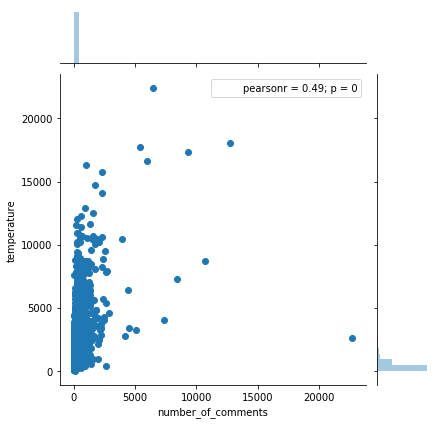

In [12]:
sns.jointplot(mydealz_data['number_of_comments'],mydealz_data['temperature'])

Is there a linear relationship between discount and temperature?

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


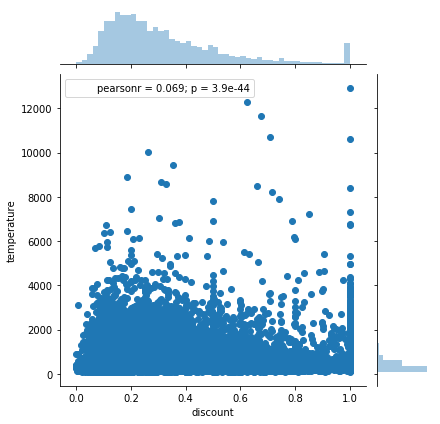

In [13]:
sns.jointplot(mydealz_data['discount'],mydealz_data['temperature'])

## Users

How many unique users posted deals for the given time?

In [14]:
mydealz_data['username'].nunique()

20634

Who are the users with the most deals?

In [15]:
mydealz_data[['title','username']].groupby(by='username').count().sort_values(by='title',ascending=False).head(10)

,title
username,
Funmilka,3235
Search85,1639
jamesblond,956
Alexcio,783
Xeswinoss,737
Barney,642
Xdiavel,571
Ansomat3000,520
dani.chii,412


## Number of Comments

What were the 10 deals with the most comments?

In [16]:
mydealz_data.sort_values('number_of_comments',ascending=False).head(10)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
58681,Amazon Warehouse Deals Sammelthread,2615,NaN,NaN,NaN,xell1984,22733,0,Heute sind einige WHD Produkte stark im Preis gesunken. Deshalb stelle ich euch ein paar Angebote hier rein. Ich werde die Liste im Laufe des Tages fortlaufend erweitern. Ich verzichte dabei auf Idealo Preisvergleich.Alle Produkte findet ihr im ersten Kommentar. Ihr könnt gerne eure Funde ebenfalls hier einstellen.,2016-05-13,https://www.mydealz.de/deals/amazon-warehouse-deals-sammelthread-726999
51320,10€ Rabatt ohne MBW (unbegrenzt oft) auf alles bei Amazon durch Spiele-Gutscheinfehler,18021,NaN,NaN,NaN,philippmb,12770,0,"Auch auf die Gefahr hin, dass nun alles was ich bestellt habe gecancelled wird, hier ein grandioser Deal:Legt ein Spiel bei Amazon in den Einkaufswagen (wichtig, dass es kein Marketplacehändler, sondern Amazon selber ist) und geht zur Kasse.Es werden dann 10€ abgezogen.Ihr könnt jetzt einfach noch ein anderes Produkt in den Warenkorb legen (einzige Bedingung: ""Verkauf und Versand durch Amazon"") und das Spiel dann an der Kasse (also im letzten Bestellschritt) wieder entfernen. Die 10€ Rabatt bleiben bestehen!Somit extrem viele Freebies möglich.Funktioniert sooft man möchte.Auf zwei Accounts getestet.",2018-07-02,https://www.mydealz.de/deals/10eur-rabatt-ohne-mbw-unbegrenzt-oft-auf-alles-bei-amazon-durch-spiele-gutscheinfehler-1126286
57617,COMMERZBANK: 200€ Startguthaben - UPDATE: Jetzt live!,8730,NaN,NaN,NaN,ChristophHese,10693,0,"UPDATEDie Aktion ist jetzt live! Und somit gehts los mit der Commerzbank und der aktuell höchsten Prämie für ein kostenfreies Girokonto, nämlich 200€ und für diese muss man nicht mal allzu viel tun.CommerzbankKosten: 0€ pro Monat (kostenfrei bei privater Nutzung - komplett ohne Umsatzgrenzen)Besonderheiten: kostenlos Bargeld abheben an allen Cash-Group Automaten (Commerzbank, Deutsche Bank, Postbank, HypoVereinsbank und deren Tochterbanken) und an vielen Shell TankstellenphotoTAN oder mobileTAN stehen zur Auswahlseit dem Relaunch ein sehr gutes Online-Banking InterfaceVideo-Legitimation möglich (so kein nerviger Gang zur Post fürs Post-Ident Verfahren)Die Prämie bekommt man logischerweise nur als Neukunde (kein Commerzbank Konto in den letzten 24 Monaten)Das Konto ist wirklich perfekt für alle, die gerne ein Konto bei einer Filialbank haben wollen. Eine Kreditkarte ist nicht kostenlos dabei, aber dafür gibt es ja zahlreiche andere gute Alternativen.Was auch noch ganz cool ist, dass...",2016-11-24,https://www.mydealz.de/deals/commerzbank-200eur-startguthaben-update-jetzt-live-880496
57374,"(02.-03.01) Mehrwertsteuer geschenkt bei Saturn - 15,97% Rabatt (online und offline) Media Markt Gutscheine einlösbar",17301,NaN,NaN,NaN,GelöschterUser692430,9341,0,"Ursprünglicher Deal vom 20.12.2016 - 00:44:So Leute, da heute die Gutschein Aktion beginnt wollt ich euch über einen weiteren Leak-Kracher informieren.Am 02. und 03.1.2017 wird es Bei Saturn eine Mehrwertsteuer Rabatt Aktion geben. Bei der ihr 15,966 % sparen könnt.Nach meiner Information auf alles, wobei ich annehme, das Gutscheine und Voucher Cards etc ausgeschlossen sind. Ebenfalls kann ich noch nicht sagen ob es nur offline stattfindet oder auch online. Aber zu 100% offline. Also wer am 27. seine Gutscheine schon einlösen wollte, sollte die paar Tage definitiv noch warten. Ich halte euch auf dem laufenden bei Neuigkeiten. Gerne könnt ihr aber diesen Deal als Sammelthread für besonders gute Schnapper benutzen",2016-12-21,https://www.mydealz.de/deals/02-0301-mehrwertsteuer-geschenkt-bei-saturn-1597-rabatt-online-und-offline-media-markt-gutscheine-einlosbar-914896
56430,GameStop PS4 Pro Eintauschaktion,7249,NaN,99.99,NaN,GelöschterUser573021,8453,0,"Wieder einmal gibt es bei Gamestop eine Eintauschaktion mit der PS4 Pro ab dem 26.04.2017.Die Konditionen sind recht einfach:Alte PS4 inkl. Controller und zwei Spielen abgeben und eine n

## Local Deals

Comparison between local and non-local deals

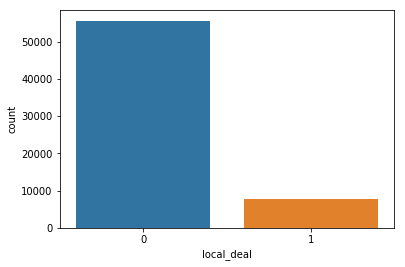

In [86]:
sns.countplot(mydealz_data['local_deal'])

What were the top 3 hottest local deals?

In [90]:
mydealz_data[mydealz_data['local_deal'] == 1].sort_values(by='temperature',ascending=False).head(3)

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
24072,"Conrad 19% Rabatt auf fast Alles - z.B. iPhone Xs für 935€, Xs Max für 1012,50€",8884,1150.0,935.00,0.186957,Niklas_HVHv,2357,1,"Edit: Das Malbuch wird nur noch selten angeboten sollen aber wieder welche kommen am besten vorher erkundigen oder:Jedoch gibt es bis 14.10.2018 15 Fach Payback mit denen ein rechnerischer Rabatt von 7,5% der Kombiniert mit den 10% auf die ConradGutscheinkarten 17,5% ergibt. Hierfür muss über die Paybackapp eingekauft werden. Bitte für weitere Infos hierfür die Kommentare beachten, da ich mich mit Payback nicht so gut auskenne. Ich versuche das hier noch genauer zu machenEdit ende—————Durch die Kombination &lt;strong&gt;der Rewe Geschenkgutscheinrabattaktion&lt;/strong&gt; und dem -10% Malbuch-Rabatt, ergeben sich einige sehr gute Preise bei Conrad, bspw. 935€ für das iPhone Xs 64GB oder 1012,50€ für das iPhone Xs Max‌ 64GB.Ihr müsst wie folgt vorgehen:Einfach bei Rewe Geschenkgutscheine für den Produktpreis -10% kaufen und an der Kasse dank der Aktion -10% auf den Geschenkgutscheinwert sparen. Anschließend zu Conrad, Artikel nehmen, damit zur Kasse und das Heft mit dem -10% Punkte...",2018-08-10,https://www.mydealz.de/deals/conrad-19-rabatt-auf-fast-alles-zb-iphone-xs-fur-935eur-xs-max-fur-101250eur-1246917
52935,Gratis Pizza für Obdachlose und Hilfebedürfige - Herne HBF - Pizzeria Arena LOKAL,8432,NaN,NaN,NaN,KNaschke,350,1,"Nein Jungs + Mädels, nicht ausnutzen.Nein, kein Usertreffen.Nein, kein Laden stürmen.Die Pizzeria in Herne am HBF gibt an Heiligabend von 14-17 Uhr gratis Pizza an Hilfebedürftige und Obdachlose aus.Pizzeria ArenaBahnhofsplatz 344629 HerneIch wiederhole:Nein Jungs + Mädels, nicht ausnutzen.Nein, kein Usertreffen.Nein, kein Laden stürmen.Meiner Meinung nur eine super Aktion, welche man gerne weitersagen darf, wenn man aus der Region kommt. Natürlich auch nur an Hilfebedürftige etc. die sonst eventuell das Angebot nicht mitbekommen werden.---------------------------------------------------------------------------------------------------------Nachträglich hinzugefügt:Ich erhoffe mir durch das Teilen eventuelle Aktionen in die gleiche Richtung von anderen Imbissen etc.Wenn durch diesen Post nur ein Laden mehr mitmacht, hat es sich mehr als gelohnt.---------------------------------------------------------------------------------------------------------Nachträglich hinzugefügt die Zweite...",2017-12-20,https://www.mydealz.de/deals/gratis-pizza-fur-obdachlose-und-hilfebedurfige-herne-hbf-pizzeria-arena-lokal-1099980
47586,"[Lokal][McDonald's] Big Mac mit 10 Patties (5xFleisch) für 3,99 (450g Fleisch)",7474,NaN,3.99,NaN,AdmiralPPR,613,1,"Hallo liebe Community,beim Big Mac Jubiläum haben wir zufällig entdeckt, dass zusätzliches Beef für 50cent bestellt werden kann. Hinzu kommt, dass ""1xBeef"" beim Big Mac offenkundig 2 Patties entspricht.(evtl. nur lokal in Aschaffenburg - bestellt am self service terminal)Da man maximal 4 Zutaten extra bestellen kann, macht das 5 mal Beef auf dem Big Mac. Das macht insgesamt 10 Patties für 3,99Auch nett sind z.B. 2 Big Macs mit je 4 Patties für insg. 4,98Lasst gerne einen Kommentar da, wenn ihr es ausprobiert habt, ob es bei euch funktioniert hat.Update: Es scheint wohl Zufall zu sein, ob man doppelt Patties bekommt.Schaut am besten in die Kommentare, in welchen Filialen es geht!PS: Mein erster Deal - Anregungen willkommen ^^",2018-04-04,https://www.mydealz.de/deals/lokalmcdonalds-big-mac-mit-10-patties-5xfleisch-fur-399-450g-fleisch-1155652


# Linear Regreession

MAE: 288.5794455008757
MSE: 271741.7692924544
RMSE: 521.2885662399036


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


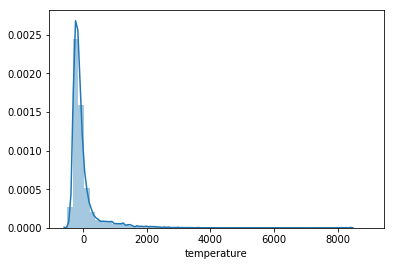

In [93]:
from sklearn.linear_model import LinearRegression

#removing NaN values
no_missing_values = mydealz_data.dropna(axis=0)

#selecting featurees
X = no_missing_values[['old_price','new_price','discount']]
y = no_missing_values['temperature']

#splittting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#creeating model
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
predictions = linear_regression.predict(X_test)

#evaluating model
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

sns.distplot((y_test-predictions),bins=50)
plt.scatter(y_test,predictions)

# Natural Language Processing

## Classifying different deals into classes

In [147]:
def temperature_classification(temp):  
        if temp < 500:
            temp = 1
            return temp
        elif temp < 750:
            temp = 2
            return temp
        elif temp < 1000:
            temp = 2
            return temp
        elif temp < 2000:
            temp = 3
            return temp
        elif temp < 4000:
            temp = 4
            return temp
        elif temp < 8000:
            temp = 5
            return temp
        elif temp > 8000:
            temp = 6
            return temp

In [148]:
mydealz_data['temperature_encoded'] = mydealz_data['temperature'].apply(temperature_classification)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [149]:
mydealz_data.groupby('temperature_encoded').count()

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link
temperature_encoded,,,,,,,,,,,
1,46411,46411,31049,41110,31049,46411,46411,46411,46390,46411,46411
2,10212,10212,6244,8585,6244,10212,10212,10212,10208,10212,10212
3,4574,4574,2558,3752,2558,4574,4574,4574,4573,4574,4574
4,1836,1836,903,1317,903,1836,1836,1836,1836,1836,1836
5,322,322,95,177,95,322,322,322,322,322,322
6,60,60,13,27,13,60,60,60,60,60,60


In [145]:
mydealz_data[mydealz_data['temperature_encoded'].isna()]

,title,temperature,old_price,new_price,discount,username,number_of_comments,local_deal,description,publication_date,deal_link,temperature_encoded


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


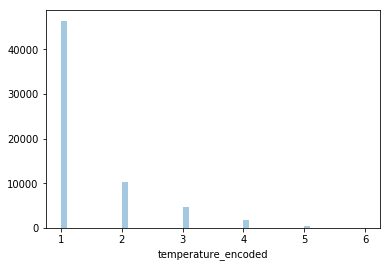

In [146]:
sns.distplot(mydealz_data['temperature_encoded'],kde=False)

## Text Pre-processing

**Requirements: You will need to have NLTK installed, along with downloading the corpus for stopwords. To download everything with a conda installation, run the cell below. Or reference the full video lecture**

In [19]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# WATCH THE VIDEO FOR FULL INSTRUCTIONS ON THIS STEP

# Uncomment the code below and run:


# !conda install nltk #This installs nltk
# import nltk # Imports the library
# nltk.download() #Download the necessary datasets

In [27]:
from nltk.corpus import stopwords
import string

In [28]:
def text_process(text):
    """
    1. remove punc
    2. remove stop words
    3. return list of celan text words
    
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('german')]

In [35]:
#checking the first 10 descriptions

for description_no, description in enumerate(mydealz_data['title'][0:10]):
    print(description_no,description)
    print('\n')

0 Seeberger Müsliglück Sunday Morning, 6er Pack (6 x 325 g) [AMAZON Sparabo]


1 Philips Hue White and Color Ambiance E14 LED Kerze Doppelpack inkl. Hue Dimmschalter, dimmbar, steuerbar via App, für 75,59€ (Amazon)


2 [Regional Mediamarkt Nordhorn-Tagesangebot am 10.12]  Bose SoundTouch 10 / Doppelpack schwarz für 249,-€


3 Notebooksbilliger Adventskalender - Benq EW3270ZL, Odys Winbook 14


4 Philips Hue LightStrip Plus Set 3m - Basis Set & Erweiterung für 59,99€ inkl. Versand // Auch bei Mediamarkt


5 Philips 55 PUS 8503 mit 3-fachem Ambilight, 120Hz


6 Hereditary für 0,99€ bei Amazon Prime Video leihen


7 [Regional Mediamarkt Bayreuth] Verschiedene Nintendo Switch Spiele für je 44,-€ mit Zb. Super Smash Bros. Ultimate  oder Zelda (3für2)


8 [Prime] Leitz Mini-Heftgerät und Mini-Locher Set + 1000 Heftklammern, orange metallic


9 [Rosegal]  Wiederaufladbere ergonomische vertikale Funkmaus HXSJ T22  2.4GHz für 5€




In [46]:
# Check to make sure its working
mydealz_data['title'].head(5).apply(text_process)

0                                                                [Seeberger, Müsliglück, Sunday, Morning, 6er, Pack, 6, x, 325, g, AMAZON, Sparabo]
1    [Philips, Hue, White, and, Color, Ambiance, E14, LED, Kerze, Doppelpack, inkl, Hue, Dimmschalter, dimmbar, steuerbar, via, App, 7559€, Amazon]
2                                               [Regional, Mediamarkt, NordhornTagesangebot, 1012, Bose, SoundTouch, 10, Doppelpack, schwarz, 249€]
3                                                                           [Notebooksbilliger, Adventskalender, Benq, EW3270ZL, Odys, Winbook, 14]
4                                              [Philips, Hue, LightStrip, Plus, Set, 3m, Basis, Set, Erweiterung, 5999€, inkl, Versand, Mediamarkt]
Name: title, dtype: object

# Vectorization

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(mydealz_data['title'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

85950


In [50]:
title4 = mydealz_data['title'][4]
print(title4)

Philips Hue LightStrip Plus Set 3m - Basis Set & Erweiterung für 59,99€ inkl. Versand // Auch bei Mediamarkt


In [53]:
bow4 = bow_transformer.transform([title4])
print(bow4)
print(bow4.shape)

  (0, 10644)	1
  (0, 13506)	1
  (0, 22284)	1
  (0, 32484)	1
  (0, 41344)	1
  (0, 47862)	1
  (0, 50561)	1
  (0, 56983)	1
  (0, 57441)	1
  (0, 64665)	2
  (0, 73156)	1
  (0, 81205)	1
(1, 85950)


In [55]:
print(bow_transformer.get_feature_names()[64665])

Set


In [56]:
title_bow = bow_transformer.transform(mydealz_data['title'])

In [57]:
print('Shape of Sparse Matrix: ', title_bow.shape)
print('Amount of Non-Zero occurences: ', title_bow.nnz)

Shape of Sparse Matrix:  (63415, 85950)
Amount of Non-Zero occurences:  559984


In [59]:
sparsity = (100.0 * title_bow.nnz / (title_bow.shape[0] * title_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


# TF-IDF

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(title_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 81205)	0.15688467811808468
  (0, 73156)	0.17816919566407013
  (0, 64665)	0.4416352011934821
  (0, 57441)	0.20087014204038395
  (0, 56983)	0.2080976950959408
  (0, 50561)	0.21364228460496476
  (0, 47862)	0.3479435863073512
  (0, 41344)	0.25089495088425984
  (0, 32484)	0.33047130138751046
  (0, 22284)	0.32734975714249753
  (0, 13506)	0.31465877690457067
  (0, 10644)	0.3462838258704503


In [61]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Amazon']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Mediamarkt']])

3.3688491674732233
5.478220262506891


In [62]:
title_tfidf = tfidf_transformer.transform(title_bow)
print(title_tfidf.shape)

(63415, 85950)


# Training a Model

In [75]:
from sklearn.naive_bayes import MultinomialNB
deal_class_model = MultinomialNB().fit(title_tfidf, mydealz_data['temperature_encoded'])

In [76]:
print('predicted:', deal_class_model.predict(tfidf4)[0])
print('expected:', mydealz_data['temperature_encoded'][3])

predicted: 1
expected: 1


# Train Test Split

In [161]:
from sklearn.model_selection import train_test_split

title_train, title_test, label_train, label_test = \
train_test_split(mydealz_data['title'], mydealz_data['temperature_encoded'],test_size = 0.7)

print(len(title_train), len(title_test), len(title_train) + len(title_test))

19024 44391 63415


# Creating a Data Pipeline

In [162]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [163]:
pipeline.fit(title_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x1147701e0>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [164]:
predictions = pipeline.predict(title_test)

In [165]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           1       1.00      0.73      0.85     44377
           2       0.00      0.25      0.00         8
           3       0.00      0.83      0.00         6
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

   micro avg       0.73      0.73      0.73     44391
   macro avg       0.17      0.30      0.14     44391
weighted avg       1.00      0.73      0.85     44391



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


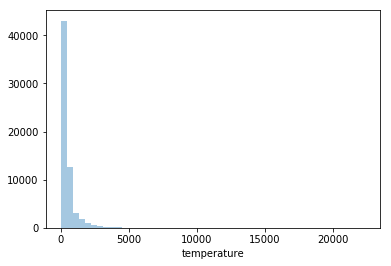

In [160]:
sns.distplot(mydealz_data['temperature'],kde=False)